In [1]:
import pandas as pd
import numpy as np
import pickle

In [3]:
import copy
import torch
import torch.nn as nn

import tqdm

ImportError: libcusparse.so.11: cannot open shared object file: No such file or directory

In [ ]:
with open('../../MLM/mpra/mpra_griesemer/regression/hpp_search_1st.pickle','rb') as f:
    data=pickle.load(f)

In [128]:
def pearson_r(x,y):
    '''
    Compute Pearson r coefficient between samples x and y
    '''
    x = np.array(x)
    y = np.array(y)
    cov_xy = np.mean((x - x.mean()) * (y - y.mean()))
    r = cov_xy / (x.std() * y.std())
    return r

In [133]:
from torch import nn
from torch.optim import AdamW

class MLPRegressor():
    def __init__(self, hidden_layer_sizes=(64,32,16,), 
                 p_dropout=0, weight_decay=0, lr=0.0005,
                batch_size = 1000, N_epochs = 500, **kwargs):
                
        self.hidden_layer_sizes = hidden_layer_sizes
        self.p_dropout = p_dropout
        self.weight_decay = weight_decay
        self.lr = lr
        
        self.batch_size = batch_size
        self.N_epochs = N_epochs
        
        self.loss_fn = nn.MSELoss()

    def init_model(self):
        
        #define model architecture
        model_layers = []
        for layer_size in self.hidden_layer_sizes:
            model_layers.extend((nn.LazyLinear(layer_size), nn.Dropout(self.p_dropout), nn.ReLU(),))
        model_layers.append(nn.LazyLinear(1))
        self.model = nn.Sequential(*model_layers)
        
        #initialize optimizer
        self.optimizer = AdamW(self.model.parameters(), weight_decay=self.weight_decay, lr=self.lr)
    
    def scorer(self, y_true, y_pred):
        y_true = y_true.detach().numpy()[:,0]
        y_pred = y_pred.detach().numpy()[:,0]
        return pearson_r(y_true, y_pred) ** 2 
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        self.init_model()
        
        self.history = [] #history for train and validation metrics
        
        batches_per_epoch = int(np.ceil(len(X_train)//self.batch_size))
        
        self.model.train()
        
        for epoch in range(self.N_epochs):
            train_score, val_score = 0, 0
            for batch_idx in range(batches_per_epoch):
                # take a batch
                X_batch = X_train[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
                y_batch = y_train[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]
                # forward pass
                y_pred = self.model(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                # backward pass
                self.optimizer.zero_grad()
                loss.backward()
                # update weights
                self.optimizer.step()
                train_score += self.scorer(y_batch, y_pred)/batches_per_epoch
            if X_val!=None:
                self.model.eval()
                y_pred = self.model(X_val)
                val_score = self.scorer(y_val, y_pred)
            self.history.append((train_score,val_score))
        
    def predict(self, X):
        
        self.model.eval()
        
        y_pred = self.model(X)
        y_pred = y_pred.detach().numpy()
        return y_pred
        
    def set_params(self, **kwargs):
        
        self.__dict__.update(kwargs)
        
    def score(self, X, y_true):
        
        y_pred = self.predict(X)
        return self.scorer(y_true,y_pred)
    
M = MLPRegressor(p_dropout=0.1,weight_decay=1e-3,batch_size=1000)
M.set_params(N_epochs=500)
M.fit(X_train,y_train,X_test,y_test)

In [134]:
y_test.shape

torch.Size([2818, 1])

In [130]:
import matplotlib.pyplot as plt

In [131]:
t,v = zip(*M.history)

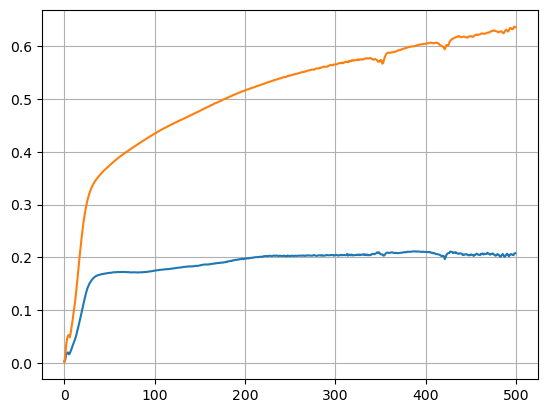

In [132]:
fig, ax = plt.subplots()
ax.plot(v)
ax.plot(t)
ax.grid()

In [ ]:
list(range(0,105,10))

In [ ]:
# Define the model
p_dropout = 0.

model = nn.Sequential(
    nn.Linear(128, 64),
    nn.Dropout(p_dropout),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.Dropout(p_dropout),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.Dropout(p_dropout),
    nn.ReLU(),
    nn.Linear(16, 1)
)

optimizer = optim.Adam(model.parameters(), lr=0.0005)

# train-test split of the dataset
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=1)
train_index, test_index = next(iter(gss.split(X, y, groups)))
X_train, X_test, y_train, y_test = X[train_index,:],X[test_index,:],y[train_index],y[test_index]
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 1000   # number of epochs to run
batch_size = 1000  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_score = -np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            train_score = pearson_r2(y_batch, y_pred)
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    test_score = pearson_r2(y_test, y_pred)
    bar.set_postfix(r2_train=train_score)
    print(train_score,test_score)
    history.append(test_score)
    if test_score < best_score:
        best_mse = test_score
        best_weights = copy.deepcopy(model.state_dict())

In [ ]:
y_pred.detach().numpy().shape

In [ ]:
y